# Simulate data using behavioral model and perform parameter recovery

There are 3 models with different parameter combinations:

1. <b>The Bayesian model (Schwöbel et al. 2021):</b> \
   <b>a.</b> With 3 parameters: a policy forgetting rate $\lambda_{\pi}$, a reward forgetting rate $\lambda_{r}$, and a decision temparature $\beta$. \
   <b>b.</b> With 4 parameters: a policy forgetting rate $\lambda_{\pi}$, a reward forgetting rate $\lambda_{r}$, a decision temparature $\beta$, and a habitual tendency $h$.
2. <b>The original model-free/model-based (MF/MB) model (Daw et al. 2005, 2011):</b> \
   <b>a.</b> With 4 parameters: a weighting parameters $\omega$, a decision temperature $\beta$, a learning rate $\alpha$, and a dicount factor $\lambda$. \
   <b>b.</b> With 5 parameters: a weighting parameter $\omega$, a decision temperature $\beta$, a learning rate $\alpha$, a dicount factor $\lambda$, and a repetition/perserveration parameter $p$.
3. <b>A newer MF/MB version that is better for fitting (Otto et al. 2013):</b> \
   <b>a.</b> With 4 parameters: a MF weight parameter $\beta_{MF}$, a MB weight parameter $\beta_{MB}$, a learning rate $\alpha$, and a dicount factor $\lambda$. \
   <b>b.</b> With 4 parameters: a MF weight parameter $\beta_{MF}$, a MB weight parameter $\beta_{MB}$, a learning rate $\alpha$, and a dicount factor $\lambda$.

Tell python that the code in the submodule is code that we want to import and run

In [1]:
import sys
sys.path.append('code/BalancingControl')

import recovery_utils as ru
import inference as inf

torch threads 1
Running on device cpu


Other imports that we need for simulation, inference, and plotting

In [2]:
import torch
import pyro

import os
from scipy.io import loadmat
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import glob
import jsonpickle as pickle
import json
import gc

Where second stage random walks from the experiment are stored

In [3]:
Rho_data_fname = os.path.join("experiment", "dawrandomwalks.mat")

Define where results should be saved

In [4]:
results_folder = "results"
simulation_folder = os.path.join(results_folder, "simulations")
recovery_folder = os.path.join(results_folder, "recovery")

#### Global experiment parameters

In [5]:
# number of simulated agents/participants
n_agents = 50

In [6]:
trials =  201#number of trials
T = 3 #number of time steps in each trial
nb = 4 # number of bandits, ie second level rewards
ns = 3+nb #number of states
no = ns #number of observations
na = 2 #number of actions
npi = na**(T-1) #number of policies
nr = 2 #number of rewards
never_reward = ns-nb # states that dont generate rewards

# prob for invalid answer (e.g. no reply). Same frequency as in the real data
p_invalid = 1.-1./201.

# make global parameter dict:
global_experiment_parameters = {"trials": trials, "T": T, "nb": nb, "ns": ns, "no": no, "na": na, "npi": npi, "nr": nr, "never_reward": never_reward, "p_invalid": p_invalid}

Define states and transition matrices

In [7]:
#generating probability of observations in each state / unity matrix
A = torch.eye(no)


#state transition generative probability (matrix)
B = torch.zeros((ns, ns, na))
b1 = 0.7
nb1 = 1.-b1
b2 = 0.7
nb2 = 1.-b2

B[:,:,0] = torch.tensor([[  0,  0,  0,  0,  0,  0,  0,],
                      [ b1,  0,  0,  0,  0,  0,  0,],
                      [nb1,  0,  0,  0,  0,  0,  0,],
                      [  0,  1,  0,  1,  0,  0,  0,],
                      [  0,  0,  0,  0,  1,  0,  0,],
                      [  0,  0,  1,  0,  0,  1,  0,],
                      [  0,  0,  0,  0,  0,  0,  1,],])

B[:,:,1] = torch.tensor([[  0,  0,  0,  0,  0,  0,  0,],
                      [nb2,  0,  0,  0,  0,  0,  0,],
                      [ b2,  0,  0,  0,  0,  0,  0,],
                      [  0,  0,  0,  1,  0,  0,  0,],
                      [  0,  1,  0,  0,  1,  0,  0,],
                      [  0,  0,  0,  0,  0,  1,  0,],
                      [  0,  0,  1,  0,  0,  0,  1,],])

# add to parameter dict
global_experiment_parameters["A"] = A
global_experiment_parameters["B"] = B

Load and plot reward probabilities

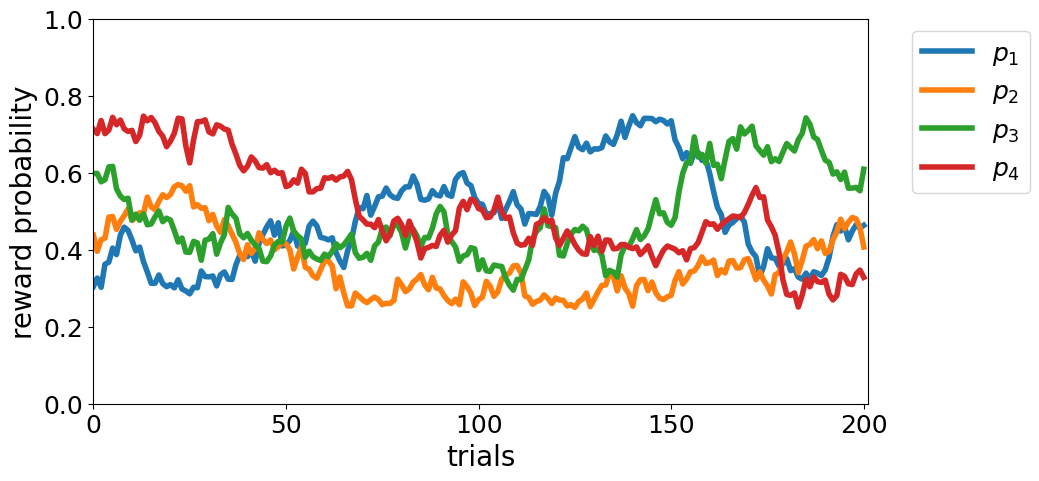

In [8]:
rew_probs = loadmat(Rho_data_fname)['dawrandomwalks']
assert trials==rew_probs.shape[-1]

Rho = torch.zeros((trials, nr, ns))

Rho[:,1,:never_reward] = 0.
Rho[:,0,:never_reward] = 1.

Rho[:,1,never_reward:never_reward+2] = torch.from_numpy(rew_probs[0,:,:]).permute((1,0))
Rho[:,0,never_reward:never_reward+2] = torch.from_numpy(1-rew_probs[0,:,:]).permute((1,0))

Rho[:,1,never_reward+2:] = torch.from_numpy(rew_probs[1,:,:]).permute((1,0))
Rho[:,0,never_reward+2:] = torch.from_numpy(1-rew_probs[1,:,:]).permute((1,0))

plt.figure(figsize=(10,5))
for i in range(4):
    plt.plot(Rho[:,1,3+i], label="$p_{}$".format(i+1), linewidth=4)
plt.ylim([0,1])
plt.yticks(torch.arange(0,1.1,0.2),fontsize=18)
plt.ylabel("reward probability", fontsize=20)
plt.xlim([-0.1, trials+0.1])
plt.xticks(range(0,trials+1,50),fontsize=18)
plt.xlabel("trials", fontsize=20)
plt.legend(fontsize=18, bbox_to_anchor=(1.04,1))
plt.savefig(os.path.join(results_folder, "twostep_prob.svg"),dpi=300)
plt.show()

# add to parameter dict
global_experiment_parameters["Rho"] = Rho

Now we can start :) 

### 2. MF/MB:
### 2.a 4 parameter version

Simulation pre-setup

In [9]:
# set parameters and their names

use_orig = False

use_p = False
restrict_alpha = False
max_dt = 6

if use_orig:
    prefix = "mbmfOrig_"
    param_names = ["discount", "learning rate", "dec temp", "weight", "repetition"]
    model_name = "original original w and beta model"
else:
    prefix = "mbmf_"
    param_names = ["discount", "learning rate", "mf weight", "mb weight", "repetition"]
    model_name = "two beta mbmf model"

if use_p:
    n_pars = 5
    p_str = "5param"
else:
    n_pars = 4
    p_str = "4param"
    param_names = param_names[:-1]
    
if restrict_alpha:
    restr_str = "_resticted"
    min_alpha = 0.1
else:
    restr_str = ""
    min_alpha = 0

# prepare for saving results
# make base filename and folder string
fname_base = prefix+p_str+restr_str+"_simulation_"
print(fname_base)
# define folder where we want to save data
base_dir = os.path.join(simulation_folder,fname_base[:-1])

mbmf_4param_simulation_


<b>Decide</b> for running or loading simulated data

In [10]:
run_simulation = True

<b>Either:</b> (re)run simulations, save parameter and behavior

In [11]:
if run_simulation:
    # make directory if it doesnt exist
    if fname_base[:-1] not in os.listdir(simulation_folder):
        os.mkdir(base_dir)
    
    # choose whether olf simulations in this folder should be deleted.
    remove_old = True

    print("simulating "+str(n_agents)+" agents...\nrandomly generating true parameter values...")
    stayed_arr, true_vals, data = ru.run_mfmb_simulations(n_agents, use_orig, use_p, restrict_alpha, fname_base, base_dir, **global_experiment_parameters, max_dt=max_dt, remove_old=remove_old)

simulating 20 agents...
randomly generating true parameter values...
{'subject': tensor([0]), 'discount': tensor([0.9830]), 'learning rate': tensor([0.4785]), 'mf weight': tensor([1.6577]), 'mb weight': tensor([4.3668]), 'repetition': tensor([0]), 'max dt': 6, 'min learning rate': 0}
torch.Size([2, 1, 1])
torch.Size([2, 1, 1])
torch.Size([2, 1, 1])
torch.Size([2, 1, 1])
torch.Size([2, 1, 1])
torch.Size([2, 1, 1])
torch.Size([2, 1, 1])
torch.Size([2, 1, 1])
torch.Size([2, 1, 1])
torch.Size([2, 1, 1])
torch.Size([2, 1, 1])
torch.Size([2, 1, 1])
torch.Size([2, 1, 1])
torch.Size([2, 1, 1])
torch.Size([2, 1, 1])
torch.Size([2, 1, 1])
torch.Size([2, 1, 1])
torch.Size([2, 1, 1])
torch.Size([2, 1, 1])
torch.Size([2, 1, 1])
torch.Size([2, 1, 1])
torch.Size([2, 1, 1])
torch.Size([2, 1, 1])
torch.Size([2, 1, 1])
torch.Size([2, 1, 1])
torch.Size([2, 1, 1])
torch.Size([2, 1, 1])
torch.Size([2, 1, 1])
torch.Size([2, 1, 1])
torch.Size([2, 1, 1])
torch.Size([2, 1, 1])
torch.Size([2, 1, 1])
torch.Size(

<b>Or:</b> load stored simulation results

In [12]:
if not run_simulation:
    print("loading simulated outputs...")
    
    stayed_arr, true_vals, data = ru.load_simulation_outputs(base_dir)

    n_true = true_vals["subject"].max() + 1
    n_data = data["subject"].max() + 1

    assert n_true == n_data == n_agents, f"the numbers of agents dont match! They are: {n_true}, {n_data}, {n_agents}. Probably rerun simulations to fix."

    print("true values are:")
    print(true_vals)

Plot simulated stay probability

/home/sarah/anaconda3/envs/two_stage/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/sarah/anaconda3/envs/two_stage/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/sarah/anaconda3/envs/two_stage/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/hom

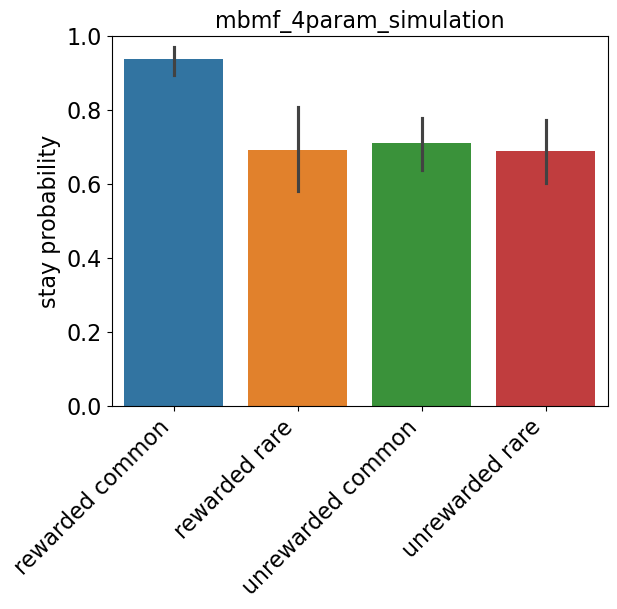

In [13]:
bar_names = ["rewarded common", "rewarded rare", "unrewarded common", "unrewarded rare"]

plt.figure()
g = sns.barplot(data=stayed_arr)
g.set_xticklabels(bar_names, rotation=45, horizontalalignment='right', fontsize=16)
plt.ylim([0,1])
plt.yticks(torch.arange(0,1.1,0.2),fontsize=16)
plt.ylabel("stay probability", fontsize=16)
plt.title(fname_base[:-1], fontsize=16)
plt.savefig(os.path.join(base_dir,"simulated_stay_probs.svg"),dpi=300)
plt.show()

#### Inference

Inference pre-setup

In [14]:
# prepare for saving results
# make base filename and folder string
fname_base = prefix+p_str+restr_str+"_recovery_"
print(fname_base)
# define folder where we want to save data
base_dir = os.path.join(recovery_folder,fname_base[:-1])

# make directory if it doesnt exist
if fname_base[:-1] not in os.listdir(recovery_folder):
    os.mkdir(base_dir)

# how many inference steps
num_steps = 700

mbmf_4param_recovery_


<b>Decide</b> for running or loading inference

In [15]:
run_inference = True

<b>Either:</b> Set up agent and inference. Run main inference loop, plot intermediate and end results

analyzing 20 data sets
this is inference using <class 'inference.GeneralGroupInference'>
taking steps 1 to 100 out of total 700


  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size([2, 1, 20])
torch.Size(

Mean ELBO 4864.83:   1%|          | 1/100 [00:02<03:32,  2.14s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 4909.45:   2%|▏         | 2/100 [00:03<02:25,  1.48s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 4872.27:   3%|▎         | 3/100 [00:04<02:05,  1.29s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 4909.43:   4%|▍         | 4/100 [00:05<02:07,  1.33s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 4797.88:   5%|▌         | 5/100 [00:06<01:57,  1.24s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 4766.17:   6%|▌         | 6/100 [00:07<01:49,  1.16s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 4718.35:   7%|▋         | 7/100 [00:08<01:44,  1.12s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 4708.08:   8%|▊         | 8/100 [00:09<01:43,  1.12s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 4712.53:   9%|▉         | 9/100 [00:11<01:44,  1.15s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 4700.72:  10%|█         | 10/100 [00:12<01:39,  1.11s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 4679.18:  11%|█         | 11/100 [00:13<01:35,  1.07s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 4654.46:  12%|█▏        | 12/100 [00:14<01:38,  1.12s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 4625.56:  13%|█▎        | 13/100 [00:15<01:35,  1.10s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 4597.36:  14%|█▍        | 14/100 [00:16<01:32,  1.08s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 4576.32:  15%|█▌        | 15/100 [00:17<01:33,  1.10s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 4549.43:  16%|█▌        | 16/100 [00:18<01:31,  1.09s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 4528.68:  17%|█▋        | 17/100 [00:19<01:28,  1.07s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 4499.96:  18%|█▊        | 18/100 [00:20<01:24,  1.03s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 4469.64:  19%|█▉        | 19/100 [00:21<01:24,  1.04s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 4449.12:  20%|██        | 20/100 [00:22<01:22,  1.03s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 4406.53:  21%|██        | 21/100 [00:23<01:19,  1.01s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 4355.11:  22%|██▏       | 22/100 [00:24<01:17,  1.00it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 4314.10:  23%|██▎       | 23/100 [00:25<01:16,  1.01it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 4256.83:  24%|██▍       | 24/100 [00:26<01:18,  1.03s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 4231.81:  25%|██▌       | 25/100 [00:27<01:15,  1.00s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 4199.35:  26%|██▌       | 26/100 [00:28<01:13,  1.00it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 4166.54:  27%|██▋       | 27/100 [00:29<01:13,  1.01s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 4121.64:  28%|██▊       | 28/100 [00:30<01:13,  1.03s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 4072.50:  29%|██▉       | 29/100 [00:31<01:10,  1.01it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 4037.20:  30%|███       | 30/100 [00:32<01:08,  1.02it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3997.60:  31%|███       | 31/100 [00:33<01:07,  1.03it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3961.00:  32%|███▏      | 32/100 [00:34<01:06,  1.02it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3927.19:  33%|███▎      | 33/100 [00:35<01:07,  1.01s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3898.50:  34%|███▍      | 34/100 [00:36<01:05,  1.01it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3870.44:  35%|███▌      | 35/100 [00:37<01:03,  1.02it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3850.06:  36%|███▌      | 36/100 [00:38<01:02,  1.03it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3818.72:  37%|███▋      | 37/100 [00:39<01:01,  1.03it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3793.36:  38%|███▊      | 38/100 [00:40<01:02,  1.01s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3771.04:  39%|███▉      | 39/100 [00:41<01:00,  1.00it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3745.70:  40%|████      | 40/100 [00:42<00:58,  1.02it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3719.84:  41%|████      | 41/100 [00:43<00:57,  1.02it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3699.20:  42%|████▏     | 42/100 [00:44<00:58,  1.01s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3672.14:  43%|████▎     | 43/100 [00:45<00:57,  1.01s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3652.69:  44%|████▍     | 44/100 [00:46<00:56,  1.00s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3631.76:  45%|████▌     | 45/100 [00:47<00:54,  1.01it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3607.79:  46%|████▌     | 46/100 [00:48<00:54,  1.01s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3589.95:  47%|████▋     | 47/100 [00:49<00:52,  1.00it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3573.44:  48%|████▊     | 48/100 [00:50<00:50,  1.02it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3557.99:  49%|████▉     | 49/100 [00:51<00:50,  1.02it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3533.11:  50%|█████     | 50/100 [00:52<00:49,  1.01it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3519.68:  51%|█████     | 51/100 [00:53<00:49,  1.01s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3509.18:  52%|█████▏    | 52/100 [00:54<00:48,  1.01s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3495.61:  53%|█████▎    | 53/100 [00:55<00:47,  1.01s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3481.70:  54%|█████▍    | 54/100 [00:56<00:45,  1.00it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3461.90:  55%|█████▌    | 55/100 [00:57<00:45,  1.01s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3440.91:  56%|█████▌    | 56/100 [00:58<00:46,  1.06s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3429.77:  57%|█████▋    | 57/100 [00:59<00:44,  1.03s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3419.86:  58%|█████▊    | 58/100 [01:00<00:42,  1.01s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3414.80:  59%|█████▉    | 59/100 [01:01<00:40,  1.00it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3403.69:  60%|██████    | 60/100 [01:02<00:42,  1.05s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3394.81:  61%|██████    | 61/100 [01:03<00:40,  1.05s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3384.30:  62%|██████▏   | 62/100 [01:04<00:38,  1.02s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3376.28:  63%|██████▎   | 63/100 [01:05<00:37,  1.01s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3367.71:  64%|██████▍   | 64/100 [01:06<00:36,  1.01s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3359.98:  65%|██████▌   | 65/100 [01:07<00:36,  1.03s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3350.55:  66%|██████▌   | 66/100 [01:08<00:34,  1.02s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3341.43:  67%|██████▋   | 67/100 [01:09<00:33,  1.01s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3332.60:  68%|██████▊   | 68/100 [01:10<00:32,  1.00s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3324.89:  69%|██████▉   | 69/100 [01:11<00:30,  1.02it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3317.34:  70%|███████   | 70/100 [01:12<00:29,  1.02it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3308.24:  71%|███████   | 71/100 [01:13<00:29,  1.00s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3298.66:  72%|███████▏  | 72/100 [01:14<00:28,  1.00s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3294.67:  73%|███████▎  | 73/100 [01:15<00:26,  1.00it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3287.39:  74%|███████▍  | 74/100 [01:16<00:25,  1.02it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3283.75:  75%|███████▌  | 75/100 [01:17<00:25,  1.00s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3279.42:  76%|███████▌  | 76/100 [01:18<00:23,  1.01it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3272.26:  77%|███████▋  | 77/100 [01:19<00:22,  1.01it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3268.21:  78%|███████▊  | 78/100 [01:20<00:22,  1.00s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3260.06:  79%|███████▉  | 79/100 [01:21<00:21,  1.01s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3253.78:  80%|████████  | 80/100 [01:22<00:20,  1.04s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3247.99:  81%|████████  | 81/100 [01:23<00:19,  1.02s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3242.87:  82%|████████▏ | 82/100 [01:24<00:18,  1.01s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3236.79:  83%|████████▎ | 83/100 [01:25<00:17,  1.00s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3230.33:  84%|████████▍ | 84/100 [01:26<00:16,  1.03s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3226.67:  85%|████████▌ | 85/100 [01:27<00:15,  1.01s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3221.46:  86%|████████▌ | 86/100 [01:28<00:13,  1.02it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3219.68:  87%|████████▋ | 87/100 [01:29<00:12,  1.04it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3216.68:  88%|████████▊ | 88/100 [01:30<00:11,  1.04it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3210.05:  89%|████████▉ | 89/100 [01:31<00:10,  1.01it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3205.61:  90%|█████████ | 90/100 [01:32<00:09,  1.02it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3203.66:  91%|█████████ | 91/100 [01:33<00:08,  1.03it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3198.84:  92%|█████████▏| 92/100 [01:34<00:07,  1.04it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3194.54:  93%|█████████▎| 93/100 [01:35<00:06,  1.05it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3192.61:  94%|█████████▍| 94/100 [01:36<00:05,  1.01it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3187.06:  95%|█████████▌| 95/100 [01:37<00:04,  1.02it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3183.15:  96%|█████████▌| 96/100 [01:38<00:03,  1.02it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3179.94:  97%|█████████▋| 97/100 [01:39<00:02,  1.02it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3175.67:  98%|█████████▊| 98/100 [01:40<00:02,  1.01s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3171.88:  99%|█████████▉| 99/100 [01:41<00:00,  1.00it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3168.26: 100%|██████████| 100/100 [01:42<00:00,  1.03s/it]


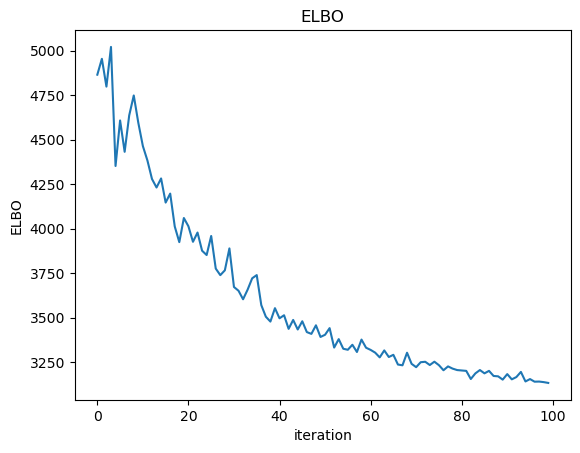

taking steps 101 to 200 out of total 700


  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3167.87:   1%|          | 1/100 [00:00<01:31,  1.08it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3142.50:   2%|▏         | 2/100 [00:02<01:41,  1.04s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3146.13:   3%|▎         | 3/100 [00:03<01:39,  1.03s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3142.23:   4%|▍         | 4/100 [00:04<01:36,  1.00s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3137.62:   5%|▌         | 5/100 [00:05<01:35,  1.01s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3137.62:   6%|▌         | 6/100 [00:06<01:33,  1.01it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3135.42:   7%|▋         | 7/100 [00:07<01:35,  1.03s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3136.83:   8%|▊         | 8/100 [00:08<01:33,  1.01s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3134.26:   9%|▉         | 9/100 [00:09<01:31,  1.00s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3130.37:  10%|█         | 10/100 [00:10<01:29,  1.00it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3127.76:  11%|█         | 11/100 [00:11<01:29,  1.00s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3125.35:  12%|█▏        | 12/100 [00:12<01:29,  1.02s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3123.05:  13%|█▎        | 13/100 [00:13<01:27,  1.00s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3121.67:  14%|█▍        | 14/100 [00:14<01:24,  1.01it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3121.42:  15%|█▌        | 15/100 [00:14<01:22,  1.03it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3119.40:  16%|█▌        | 16/100 [00:15<01:21,  1.03it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3118.54:  17%|█▋        | 17/100 [00:17<01:23,  1.01s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3117.70:  18%|█▊        | 18/100 [00:18<01:21,  1.00it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3116.56:  19%|█▉        | 19/100 [00:18<01:19,  1.01it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3114.95:  20%|██        | 20/100 [00:19<01:17,  1.03it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3110.51:  21%|██        | 21/100 [00:20<01:16,  1.04it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3110.22:  22%|██▏       | 22/100 [00:21<01:16,  1.01it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3105.85:  23%|██▎       | 23/100 [00:22<01:15,  1.01it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3103.16:  24%|██▍       | 24/100 [00:23<01:15,  1.01it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3101.55:  25%|██▌       | 25/100 [00:24<01:14,  1.00it/s]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3099.16:  26%|██▌       | 26/100 [00:25<01:16,  1.03s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3096.86:  27%|██▋       | 27/100 [00:26<01:14,  1.02s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3093.69:  28%|██▊       | 28/100 [00:28<01:13,  1.02s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3091.42:  29%|██▉       | 29/100 [00:29<01:14,  1.05s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3089.48:  30%|███       | 30/100 [00:30<01:12,  1.04s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3087.73:  31%|███       | 31/100 [00:31<01:13,  1.06s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3085.46:  32%|███▏      | 32/100 [00:32<01:10,  1.04s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3084.67:  33%|███▎      | 33/100 [00:33<01:09,  1.04s/it]

torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

Mean ELBO 3082.40:  34%|███▍      | 34/100 [00:34<01:06,  1.01s/it]


torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2, 1, 20])
torch.Size([2, 15, 20])
torch.Size([2

KeyboardInterrupt: 

In [16]:
if run_inference:

    # remove old inference?
    remove_old = False

    # set up agent
    bayes_agent = ru.set_up_mbmf_inference_agent(n_agents, use_orig, use_p, restrict_alpha, max_dt, min_alpha, base_dir, global_experiment_parameters, data["valid"], remove_old=remove_old)

    print('analyzing '+str(n_agents)+' data sets')

    # set up inference
    inferrer = inf.GeneralGroupInference(bayes_agent, data)

    num_particles = 15


    print("this is inference using", type(inferrer))
    
    size_chunk = 100
    total_num_iter_so_far = 0

    for i in range(total_num_iter_so_far, num_steps, size_chunk):
        print('taking steps '+str(i+1)+' to '+str(i+size_chunk)+' out of total '+str(num_steps))

        fname_str = fname_base + str(total_num_iter_so_far+size_chunk)+'_'+str(n_agents)+'agents'

        ru.infer(inferrer, size_chunk, fname_str, num_particles, base_dir)
        total_num_iter_so_far += size_chunk
        full_df, smaller_df, sample_df = ru.sample_posterior(inferrer, param_names, true_vals, fname_str, base_dir) 

        inferrer.save_parameters(os.path.join(base_dir, fname_str+"_parameter.save"))

        inferrer.save_elbo(os.path.join(base_dir, fname_str+"_elbo.save"))

<b>Or:</b> Set up agent and inference. Load past inference, decide whether to resample posterior or used stored samples

In [ ]:

if not run_inference:

    # set up agent
    bayes_agent = ru.set_up_mbmf_inference_agent(n_agents, use_orig, use_p, restrict_alpha, max_dt, min_alpha, base_dir, global_experiment_parameters, data["valid"], remove_old=False)

    print('analyzing '+str(n_agents)+' data sets')

    resample = False

    # set up inference
    inferrer = inf.GeneralGroupInference(bayes_agent, data)

    fname_str = fname_base + str(num_steps)+'_'+str(n_agents)+'agents'

    inferrer.load_parameters(os.path.join(base_dir, fname_str+"_parameter.save"))

    inferrer.load_elbo(os.path.join(base_dir, fname_str+"_elbo.save"))

    if resample:
        full_df, smaller_df, sample_df = ru.sample_posterior(inferrer, param_names, true_vals, fname_str, base_dir) 
    else:
        full_df, smaller_df, sample_df = ru.load_samples(base_dir, fname_str) 


In [ ]:
ru.plot_results(sample_df, param_names, fname_str, inferrer.loss, smaller_df, base_dir, max_dt)
        
print("This is recovery for the twostage task using the "+model_name+"("+prefix+p_str+restr_str+")"+" with "+str(n_agents)+" agents.")
print("The settings are: infer p", use_p, "restrict alpha", restrict_alpha)